# Connect and authorize google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ls

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

/content/gdrive/MyDrive/Colab Notebooks/GASKAP


# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
galah0 = Table.read(allstar_file)
med_dist_lim = 3000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

# For all HI absoprtion detections

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)
ggdf.head()

In [ ]:
df_det.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]
n_matchings, n_cols = current_ggdf.shape
print('Number of maching LOS: ', n_matchings)

Number of maching LOS:  302


# KI vs HI

In [ ]:
ki_hi_nsrcs = current_ggdf.shape[0]
ki_hi_nsrcs

302

In [ ]:
current_ggdf

,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,0.093995,0.105074,-6.150478,-6.150478,5.000000,-2.045776,4.104702,4.104702,1
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,0.126684,0.132525,3.705640,3.705640,5.000000,1.225603,2.480036,2.480036,1
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,0.064996,0.106274,9.394238,9.394238,5.000000,9.945510,0.551272,0.551272,1
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,0.081028,0.124206,4.061161,3.434988,3.535534,5.310693,1.249532,1.249532,2
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,0.065072,0.082032,8.506430,8.506430,5.000000,7.916428,0.590002,0.590002,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,365,J052502-693902,280.314613,-32.782629,4.766017,2.412549,4.640839,170108002201154,572.952087,0.031951,0.084907,0.086076,9.503792,9.503792,5.000000,8.739262,0.764530,0.764530,1
298,366,J052517-672245,277.639635,-33.132452,4.511694,0.286535,4.293524,161107003901184,834.148254,0.030772,0.069672,0.066543,6.387390,6.387390,5.000000,7.365472,0.978082,0.978082,1
299,374,J052648-645142,274.632554,-33.315743,4.781825,0.163477,4.665771,171205002601118,446.956665,0.031087,0.089894,0.084651,5.885810,5.885810,5.000000,5.219372,0.666438,0.666438,1
300,381,J052936-734000,284.896470,-31.671760,6.839853,0.750954,6.669797,180101003601019,492.257507,0.053339,0.091331,0.086177,7.424832,7.951100,3.535534,7.575435,0.150603,0.150603,2


In [ ]:
ki_amps = np.zeros(ki_hi_nsrcs)
ki_max_ress = np.zeros(ki_hi_nsrcs)
ki_ews = np.zeros(ki_hi_nsrcs)

peak_taus = np.zeros(ki_hi_nsrcs)
cnm_taus = np.zeros(ki_hi_nsrcs)
cnm_nhi_cpns = np.zeros(ki_hi_nsrcs)
nhi_tots = np.zeros(ki_hi_nsrcs)
nhi_thins = np.zeros(ki_hi_nsrcs)
fcnm_los = np.zeros(ki_hi_nsrcs)
fcnm_cpns = np.zeros(ki_hi_nsrcs)
cnm_ids = np.zeros(ki_hi_nsrcs, dtype='int')
for j, srci in enumerate(current_ggdf.src_name.values):
    srci_cnm_df_rows = df_cnm[df_cnm.comp_name == srci]
    ggdf_row = current_ggdf[current_ggdf.src_name == srci].iloc[0]
    df_det_row = df_det[df_det.comp_name == srci].iloc[0]

    srci_cnm_vels = srci_cnm_df_rows.cencnm.values
    srci_cnm_taus = srci_cnm_df_rows.taucnm.values
    srci_cnm_nhi_cpns = srci_cnm_df_rows.nhicnm_cpn.values
    srci_nhi_tot = srci_cnm_df_rows.nhi_tot.values
    srci_fcnm_cpn = srci_cnm_df_rows.fcnm_cpn.values


    srci_cnm_vel_selected = ggdf_row.emt_min_vlsr
    srci_ki_amp = ggdf_row.amp_ki_ism
    srci_ki_max_res = ggdf_row.res_max_ki_ism
    srci_ki_ew = ggdf_row.ew_ki_ism

    cnm_id = np.argmin(np.abs(srci_cnm_vels - srci_cnm_vel_selected))

    cnm_ids[j] = cnm_id

    ki_amps[j] = srci_ki_amp
    ki_max_ress[j] = srci_ki_max_res
    ki_ews[j] = srci_ki_ew

    peak_taus[j] = df_det_row.peak_tau
    srci_nhi_thin = df_det_row.nhi_thin

    cnm_taus[j] = srci_cnm_taus[cnm_id]
    cnm_nhi_cpns[j] = srci_cnm_nhi_cpns[cnm_id]
    nhi_tots[j] = srci_nhi_tot[cnm_id]
    fcnm_cpns[j] = srci_fcnm_cpn[cnm_id]

    nhi_thins[j] = srci_nhi_thin
    fcnm_los[j] = df_det_row['fcnm']

    # print(cnm_id, srci_cnm_taus[cnm_id], srci_cnm_nhi_cpns[cnm_id], srci_nhi_tot[cnm_id], srci_fcnm_cpn[cnm_id])

In [ ]:
current_ggdf['fcnm'] = pd.Series(fcnm_los).values
current_ggdf['fcnm_cpn'] = fcnm_cpns
current_ggdf['cnm_id'] = cnm_ids
current_ggdf['cnm_tau'] = cnm_taus
current_ggdf['cnm_nhi_cpn'] = cnm_nhi_cpns
current_ggdf['peak_tau'] = peak_taus

In [ ]:
current_ggdf

,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,...,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars,fcnm,fcnm_cpn,cnm_id,cnm_tau,cnm_nhi_cpn,peak_tau
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,...,-2.045776,4.104702,4.104702,1,0.355924,0.038223,0,0.090734,0.104369,0.194014
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,...,1.225603,2.480036,2.480036,1,0.300266,0.179441,1,0.080156,0.522056,0.130040
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,...,9.945510,0.551272,0.551272,1,0.289224,0.159254,0,0.340864,0.699697,0.401829
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,...,5.310693,1.249532,1.249532,2,0.127924,0.046216,1,0.167102,0.233673,0.395763
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,...,7.916428,0.590002,0.590002,1,0.158952,0.158110,0,0.646847,0.675642,0.696237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,365,J052502-693902,280.314613,-32.782629,4.766017,2.412549,4.640839,170108002201154,572.952087,0.031951,...,8.739262,0.764530,0.764530,1,0.062360,0.019854,0,0.094440,0.094624,1.248419
298,366,J052517-672245,277.639635,-33.132452,4.511694,0.286535,4.293524,161107003901184,834.148254,0.030772,...,7.365472,0.978082,0.978082,1,0.086365,0.086140,0,0.238382,0.388639,0.344540
299,374,J052648-645142,274.632554,-33.315743,4.781825,0.163477,4.665771,171205002601118,446.956665,0.031087,...,5.219372,0.666438,0.666438,1,0.260202,0.259674,0,0.671583,1.241713,0.822635
300,381,J052936-734000,284.896470,-31.671760,6.839853,0.750954,6.669797,180101003601019,492.257507,0.053339,...,7.575435,0.150603,0.150603,2,0.091554,0.091606,0,0.885029,0.626573,1.228973


# KI column density

In [ ]:
# Table 1, here https://articles.adsabs.harvard.edu/pdf/1974ApJ...188L..67H
ew_ki_hobbs = np.array([108., 93., 111., 79., 65., 100., 7., 45., 2.3, 4., 8., 38., 51., 79., 39., 11., 142.]) # mili-Angstrom
N_ki_hobbs = np.array([7., 5.9, 10., 7.6, 4.3, 7.5, 0.44, 3.0, 0.14, 0.25, 0.47, 2.5, 3.4, 6.9, 2.5, 0.63, 11.]) # 10^11 cm-2

N_ki_hobbs_10los = np.array([10., 7.6, 4.3, 0.44, 3.0, 0.14,  0.25, 2.5, 3.4, 6.9]) # 10^11 cm-2
N_hi_hobbs_10los = np.array([10., 12., 20.,  6.,  11.0, 1.75, 1.75, 12.5, 20., 5.])  # 10^20 cm-2

In [ ]:
gamma = 6.e-11  # s-1
alpha = 5.6e-12 # cm3 s-1
ne    = 0.06    # cm-3

In [ ]:
N_hobbs_ratio = (N_ki_hobbs_10los/ N_hi_hobbs_10los)
print('Mean, Median:', np.mean(N_hobbs_ratio), np.median(N_hobbs_ratio)) # ~0.5 e-9

Mean, Median: 0.41672510822510817 0.20750000000000002


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_thins
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.4610173436275758 0.4022902078038303


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_tots
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.42275820344063225 0.37538382249903246


# Hobbs 1974 Ki abundance

In [ ]:
stats_series = pd.DataFrame(N_hobbs_ratio).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,10.000000
mean,0.416725
std,0.446045
min,0.073333
25%,0.149643
50%,0.207500
75%,0.543182
max,1.380000


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

# KI abundance GASKAP-GALAH

In [ ]:
stats_series = pd.DataFrame(N_gg_ratio).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,302.000000
mean,0.422758
std,0.170597
min,0.159567
25%,0.306442
50%,0.375384
75%,0.500570
max,1.156478


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

In [ ]:
x_hobbs = 10*N_hobbs_ratio
x_gg = 10*N_gg_ratio

# Perform the two-sample KS test
ks_statistic, p_value = stats.ks_2samp(x_hobbs, x_gg)

print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
# print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")
print("-" * 30)

Kolmogorov-Smirnov Statistic: 0.580794701986755
P-value: 0.0012833417558293988
------------------------------


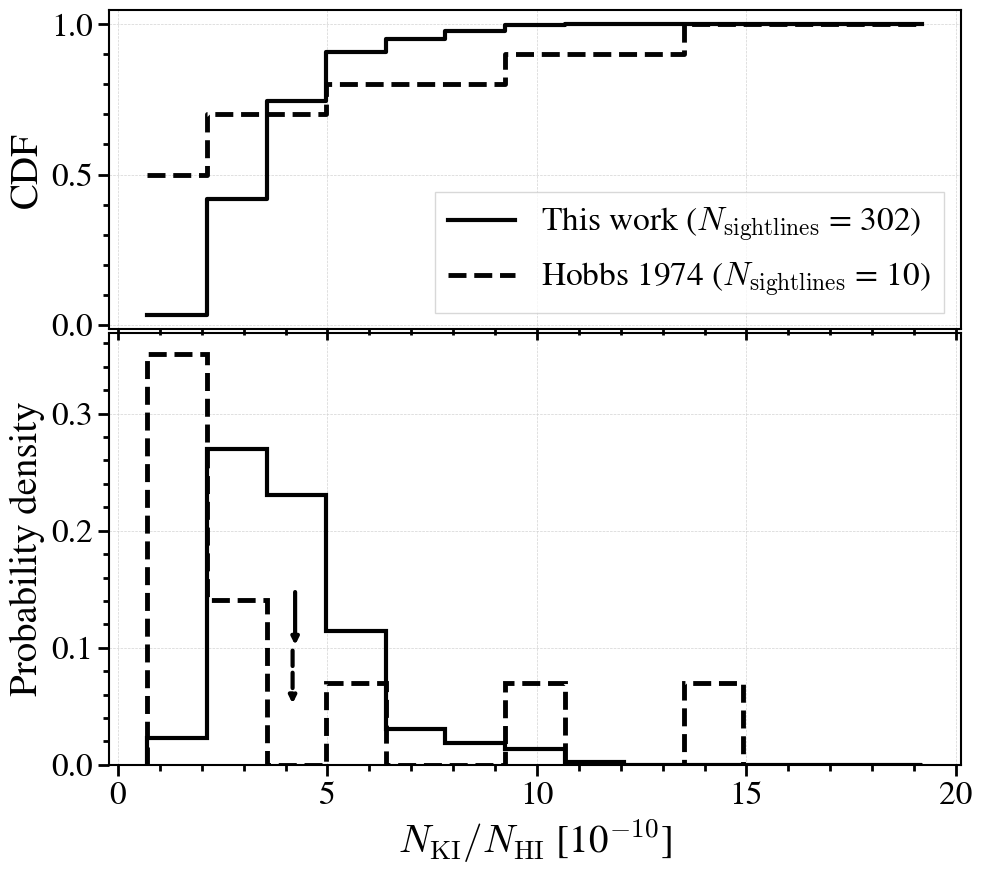

In [ ]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5



lw = 3.
binx = [10, 16, 9, 10, 5, 3]
linesty = '--'
colors = ['k', 'k', 'deepskyblue', 'gray', 'black', 'skyblue']
survey_labels = ['21-SPONGE (M15)', 'Millennium Survey (HT03)', 'Perseus (S14)', 'GMRT04', 'GNOMES', 'MACH']


xylabel = 28
xytlabel = 24


# Figure
fig = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(7, 10)
ax = plt.subplot(gs[3:7, 0:10])
ax_cdf = plt.subplot(gs[0:3, 0:10],sharex=ax)



## ax
ploti, = ax.plot([], [], 'k-', lw=lw+0.5, label='')
ploti.set_visible(True)


cnts, bins, _ = ax.hist(x_gg, bins=np.linspace(0.7, 19.2, 14),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', linewidth=lw,
         label='')

cnts1, bins1, _ = ax.hist(x_hobbs, bins=np.linspace(0.7, 19.2, 14),
         density=True, color='k', histtype='step',
         alpha=1., linestyle='--', linewidth=lw+0.5,
         label='')

## Arrows for medians
gg_med_val = np.mean(x_gg)
hobbs_med_val = np.mean(x_hobbs)
ax.annotate('', xy=(gg_med_val, 0.1), xycoords='data', xytext=(gg_med_val, 0.15), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=3., ls='-'))
ax.annotate('', xy=(hobbs_med_val, 0.05), xycoords='data', xytext=(hobbs_med_val, 0.1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=3., ls='--'))



ax.set_xlabel(r'$N_\mathrm{KI} / N_\mathrm{HI}$ [10$^{-10}$]', fontsize=xylabel)
ax.set_ylabel('Probability density', fontsize=xylabel)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)



# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='k', ls='-', lw=lw,
    alpha=0.99, label='This work ($N_\mathrm{sightlines}$ = 302)',
)


cdf3 = np.cumsum(cnts1)/np.sum(cnts1)

ax_cdf.plot(
    np.vstack((bins1, np.roll(bins1, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color=colors[1], ls=linesty, lw=lw+0.5,
    alpha=0.99, label='Hobbs 1974 ($N_\mathrm{sightlines}$ = 10)'
)


ax_cdf.minorticks_on()
ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
ax_cdf.tick_params(axis='y', labelsize=xytlabel)
ax_cdf.tick_params(which='both', width=2)
ax_cdf.tick_params(which='major', length=8)
ax_cdf.tick_params(which='minor', length=4)

ax_cdf.tick_params('y', colors='k')
ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
# ax_cdf.set_xticklabels([])
plt.setp(ax_cdf.get_xticklabels(), visible=False)

ax_cdf.legend(loc='lower right', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=24)


# Adjust the position of the second panel
pos2 = ax.get_position()
ax.set_position([pos2.x0, pos2.y0 + 0.015, pos2.width, pos2.height])


plt.show()

In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_tots
N_hobbs_ratio = (N_ki_hobbs_10los/ N_hi_hobbs_10los)

In [ ]:
xv = nhi_tots
xv_lab = r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]'
yv = N_ki_is/10.
yv_lab = '$N_\mathrm{KI}$ [10$^{11}$ cm$^{-2}$]'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)

In [ ]:
print(f"Pearson correlation coefficient: {pearson_corr}")
print(f"p-value: {p_value}")

Pearson correlation coefficient: 0.2677186837825991
p-value: 2.3631898204062607e-06


In [ ]:
statpr, statpp = stats.pearsonr(xv, yv)
statspr, statspp = stats.spearmanr(xv, yv)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.2677186837825991 , p-value = 2.3631898204062607e-06
nhi vs nki: spearman coefficient, statistic = 0.27692971020336205 , p-value = 1.0160382340270888e-06


In [ ]:
statpr, statpp = stats.pearsonr(N_ki_hobbs_10los, N_hi_hobbs_10los)
statspr, statspp = stats.spearmanr(N_ki_hobbs_10los, N_hi_hobbs_10los)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.3106228948215168 , p-value = 0.3823655666941808
nhi vs nki: spearman coefficient, statistic = 0.4451302263229461 , p-value = 0.1973570541531603


In [ ]:
ki_abund_ratio_hobbs = N_ki_hobbs_10los / N_hi_hobbs_10los
np.mean(ki_abund_ratio_hobbs)

np.float64(0.41672510822510817)

Pearson correlation coefficient: 0.2677
p-value: 0.0000


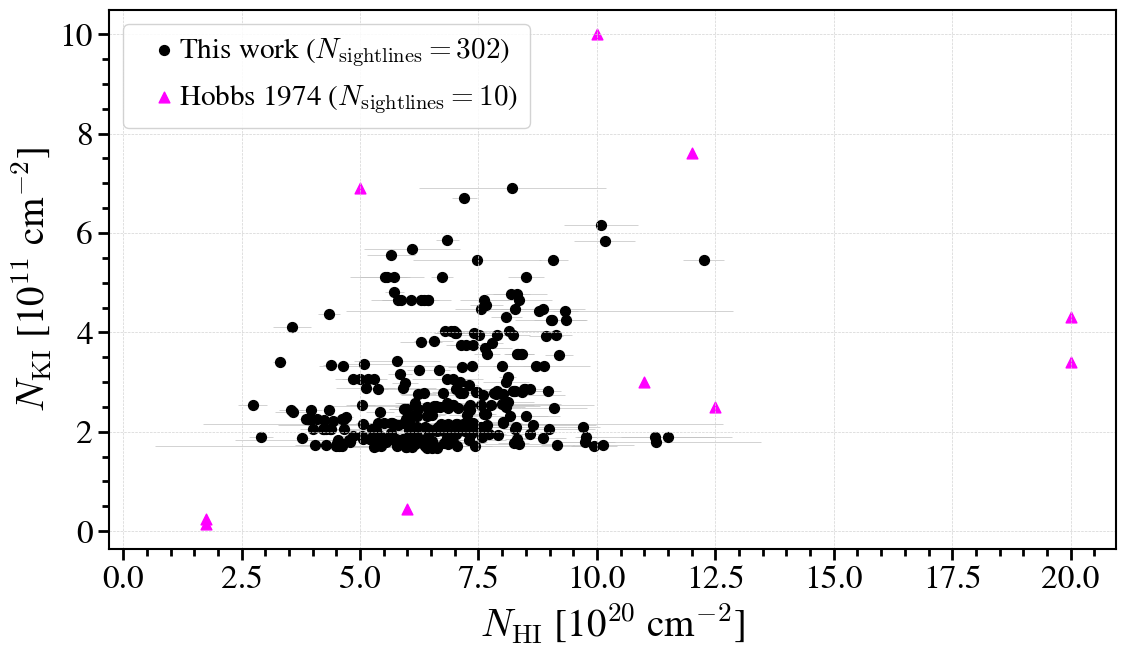

In [ ]:
print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.4f}")


# Plot
fig = plt.figure(figsize=(13,7))

ax = plt.subplot(111)

ax.errorbar(xv, yv,
             xerr=current_ggdf.sig_nhi.values, yerr=yv*0., zorder=0,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


ax.scatter(xv, yv, zorder=1, s=50, marker='o',
                 c='k', #cmap=cm,
                 label='This work ($N_\mathrm{sightlines} = 302$)')


ax.scatter(N_hi_hobbs_10los, N_ki_hobbs_10los, zorder=1, s=60, marker='^',
                 c='magenta', #cmap=cm,
                 label='Hobbs 1974 ($N_\mathrm{sightlines} = 10$)')



# Add axes labels
ax.set_xlabel(xv_lab, fontsize=28, fontweight='normal')
ax.set_ylabel(yv_lab, fontsize=28)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

ax.legend(loc='upper left', fancybox=True, framealpha=0.85, labelcolor='k', fontsize=21, handletextpad=-0.5)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()